[SAMPLE CODE]
# Pythonプログラムの基本：H2Oai OSSによるクラスタ分析
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html#install-in-python

このサンプルコードでは、次のことができます
- データセット（CSVファイル）の読み込み
- H2Oaiによる機械学習モデルの生成
- 機械学習モデルを使った予測
- 機械学習モデルの保存

In [1]:
import pandas as pd
import numpy as np

import h2o
from h2o.estimators import H2OKMeansEstimator

import matplotlib.pyplot as plt
import japanize_matplotlib

import seaborn as sns

/Users/hiroyasu.komaki/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


#### 環境PATH

In [2]:
csv_path = 'csv/'
model_path = 'model/'

fname = 'titanic_train'
fname2 = 'titanic_test'
fname3 = 'titanic_gender_submission'

## データセットの読み込み（訓練用・テスト用）

In [3]:
def show_chart(df):
    female = df.query("Sex == 'female'")
    male = df.query("Sex == 'male'")

    plt.title('Female vs Male (Bar Graph)')
    plt.bar(['Female', 'Male'], [len(female), len(male)], color=['mistyrose', 'lightblue'])
    plt.show()

In [4]:
# 訓練データ
df_train = pd.read_csv(csv_path + fname +'.csv')
df_train.shape

(891, 12)

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


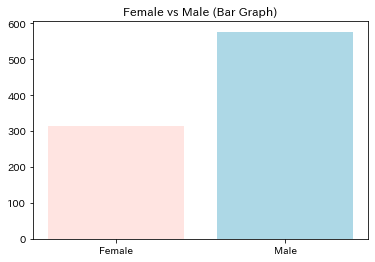

In [6]:
# 図示
show_chart(df_train)

In [7]:
# テストデータ
df_test = pd.read_csv(csv_path + fname2 +'.csv')
df_test.shape

(418, 11)

In [8]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


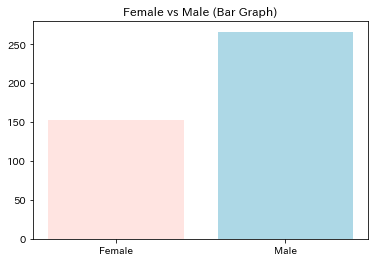

In [9]:
# 図示
show_chart(df_test)

## データ前処理

In [10]:
# 　学習に合わせてデータ前処理を行う

#### 分析軸の設定

In [11]:
axis_x = 'Age'
axis_y = 'Fare'

## 機械学習（K-Means）

#### H2Oaiの起動

In [12]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "13.0.2" 2020-01-14; OpenJDK Runtime Environment (build 13.0.2+8); OpenJDK 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/hiroyasu.komaki/.pyenv/versions/3.7.4/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/cr/k_wktw_j2pv6tbndmc83x92r0000gp/T/tmptg_6r1tf
  JVM stdout: /var/folders/cr/k_wktw_j2pv6tbndmc83x92r0000gp/T/tmptg_6r1tf/h2o_hiroyasu_komaki_started_from_python.out
  JVM stderr: /var/folders/cr/k_wktw_j2pv6tbndmc83x92r0000gp/T/tmptg_6r1tf/h2o_hiroyasu_komaki_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_hiroyasu_komaki_fha01i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


#### （H2Oai用）Dataset生成

In [13]:
train = h2o.H2OFrame(df_train)
train.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(891, 12)

In [14]:
test = h2o.H2OFrame(df_test)
test.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(418, 11)

In [15]:
train.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,nan,7.25,nan,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,nan,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,nan,7.925,nan,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,nan,S
6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.4583,nan,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,nan,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,nan,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,nan,C


In [16]:
train = train[:,[axis_x, axis_y]]

In [17]:
train.head()

Age,Fare
22,7.25
38,71.2833
26,7.925
35,53.1
35,8.05
nan,8.4583
54,51.8625
2,21.075
27,11.1333
14,30.0708


#### 機械学習モデルの生成

In [21]:
model = H2OKMeansEstimator(k=4, init="Random", seed=2, standardize=True)
model.train(x=train.col_names, training_frame = train)

kmeans Model Build progress: |████████████████████████████████████████████| 100%


## 学習済みモデルでの予測実行

In [22]:
# Predict
pred = model.predict(train)
pred['predict'].unique()

kmeans prediction progress: |█████████████████████████████████████████████| 100%


C1
2
0
1
3


## 予測結果の図示

In [23]:
# Adding the predictions values as a new column to given dataset and then setting it as enum or categorical
train["labels"] = pred["predict"].asfactor()
train.head()

Age,Fare,labels
22,7.25,2
38,71.2833,0
26,7.925,1
35,53.1,1
35,8.05,1
nan,8.4583,1
54,51.8625,0
2,21.075,2
27,11.1333,1
14,30.0708,2


In [36]:
# Converting the Prediction values to a numpy array of int32 type
pred_array = np.array(pred.as_data_frame()['predict'].values.tolist(), dtype=np.int32)
# pred_array

In [25]:
# Extracting each column values from the given dataset as a list
f1 = train.as_data_frame()[axis_x].values
f2 = train.as_data_frame()[axis_y].values

Text(0.5, 1.0, '<< Result >>')

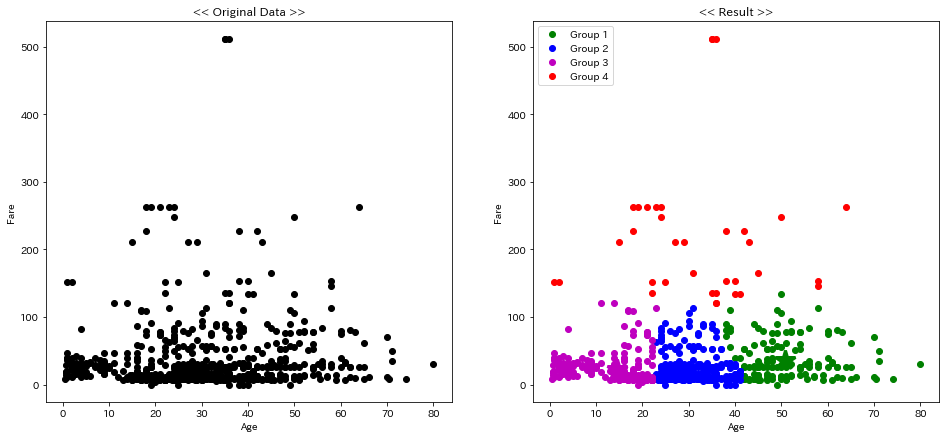

In [49]:
plt.figure(figsize=(16,7))

ax1 = plt.subplot(1, 2, 1)

# クラスター分析前
plt.plot(train.as_data_frame()[axis_x],train.as_data_frame()[axis_y],'ko')

plt.ylabel(axis_y)
plt.xlabel(axis_x)

ax1.set_title("<< Original Data >>")

ax2 = plt.subplot(1, 2, 2)

# クラスター分析結果
h1,=plt.plot(f1[pred_array==0],f2[pred_array==0],'go')
plt.plot(np.mean(f1[pred_array==0]),np.mean(f2[pred_array==0]),'g*',markersize=20,mew=3)

h2,=plt.plot(f1[pred_array==1],f2[pred_array==1],'bo')
plt.plot(np.mean(f1[pred_array==1]),np.mean(f2[pred_array==1]),'b*',markersize=20,mew=3)

h3,=plt.plot(f1[pred_array==2],f2[pred_array==2],'mo')
plt.plot(np.mean(f1[pred_array==2]),np.mean(f2[pred_array==2]),'m*',markersize=20,mew=3)

h4,=plt.plot(f1[pred_array==3],f2[pred_array==3],'ro')
plt.plot(np.mean(f1[pred_array==3]),np.mean(f2[pred_array==3]),'r*',markersize=20,mew=3)

plt.ylabel(axis_y)
plt.xlabel(axis_x)

plt.legend([h1,h2,h3,h4],['Group 1','Group 2','Group 3','Group 4'], loc='upper left')

ax2.set_title("<< Result >>")


## 学習済みモデルの保存
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/save-and-load-model.html

In [38]:
# save the model
model_path = h2o.save_model(model=model, path=model_path, force=True)
print(model_path)

/Users/hiroyasu.komaki/h2oai-bigdata-pilot/sample_code/h2oai/model/KMeans_model_python_1589680568183_1
